In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import itertools
import math
import multiprocess
from dataclasses import dataclass
from pathlib import Path
from functools import partial
from typing import Callable, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import seaborn as sns
from tqdm.notebook import tqdm

import score_analysis
from score_analysis import BinaryLabel, BootstrapConfig, Scores
from score_analysis.experimental.roc_ci import (
    NormalDataset, 
    fixed_width_band_ci,
    pointwise_band_ci,
    roc, 
    roc_with_ci, 
    simultaneous_joint_region_ci,
)

In [3]:
sns.set_style("darkgrid")
sns.set_context("notebook")

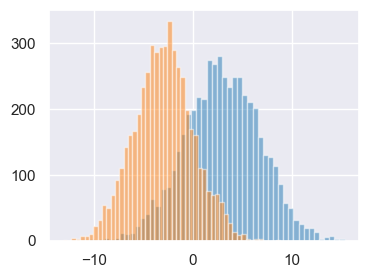

In [4]:
# Fig. 3 in Macskassy
dataset = NormalDataset(mu_pos=3.0)
scores = dataset.sample(n=10_000)

plt.figure(figsize=(4, 3))
plt.hist(scores.pos, bins=50, alpha=0.5)
plt.hist(scores.neg, bins=50, alpha=0.5)
plt.show()

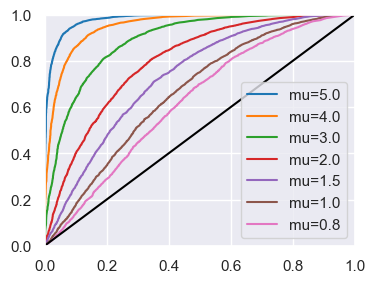

In [5]:
# Fig. 4 in Macskassy
plt.figure(figsize=(4, 3))
for mu_pos in [5., 4., 3., 2., 1.5, 1., 0.75]:
    dataset = NormalDataset(mu_pos=mu_pos)
    scores = dataset.sample(n=10_000)

    fpr, fnr = roc(scores, fpr=np.linspace(0., 1., 1_000, endpoint=True))
    tpr = 1. - fnr
    
    plt.plot(fpr, tpr, label=f"mu={mu_pos:.1f}")

plt.plot([0, 1], [0, 1], "k-")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.show()

## Coverage test with exact ROC curve

This is the corrected test setting of Sect. 5.1.

In [6]:
def coverage_test_exact(
    dataset: NormalDataset,
    ci_func: Callable,
    nb_runs: int,
    nb_roc_points: int = 1_000,
    verbose: bool = False,
):
    x = np.linspace(0., 1., nb_roc_points, endpoint=True)
    true_fnr, true_fpr = dataset.roc(fnr=x)

    results = {
        "fnr": [], 
        "fpr": [], 
        "fnr_ci": [], 
        "fpr_ci": [], 
        "fnr_inside": [], 
        "fpr_inside": [],
    }
    
    for j in tqdm(range(nb_runs), disable=not verbose, leave=False):
        scores = dataset.sample()
        fnr, fpr, fnr_ci, fpr_ci = ci_func(scores)

        # FNR is increasing and FPR is decreasing along the ROC curve, but np.interp
        # requires an increasing sequence of support points.
        lower = np.interp(true_fpr, fpr[::-1], fnr_ci[::-1, 0])
        upper = np.interp(true_fpr, fpr[::-1], fnr_ci[::-1, 1])
        fnr_inside = (lower <= true_fnr) & (true_fnr <= upper)
        
        lower = np.interp(true_fnr, fnr, fpr_ci[:, 0])
        upper = np.interp(true_fnr, fnr, fpr_ci[:, 1])
        fpr_inside = (lower <= true_fpr) & (true_fpr <= upper)

        results["fnr"].append(fnr)
        results["fpr"].append(fpr)
        results["fnr_ci"].append(fnr_ci)
        results["fpr_ci"].append(fpr_ci)
        results["fnr_inside"].append(fnr_inside)
        results["fpr_inside"].append(fpr_inside)

    for k, v in results.items():
        results[k] = np.stack(v, axis=0)
    results["true_fnr"] = true_fnr
    results["true_fpr"] = true_fpr

    results["fnr_coverage_prob"] = np.mean(np.all(results["fnr_inside"], axis=-1))
    results["fpr_coverage_prob"] = np.mean(np.all(results["fpr_inside"], axis=-1))

    return results

In [13]:
def visualise_ci_bands(ci_method_name: str, ci_func: Callable):
    dataset = NormalDataset(
        mu_pos=3.0,
        sigma_pos=3.75,
        sigma_neg=3.0,
        p_pos=0.5,
        n=500,
    )

    alpha = 0.1
    nb_runs = 200
    nb_points = 1_000
    
    results = coverage_test_exact(
        dataset=dataset,
        ci_func=partial(
            ci_func, 
            nb_points=nb_points,
            alpha=alpha,
        ),
        nb_runs=nb_runs,
        nb_roc_points=nb_points,
        verbose=True
    )

    fnr_reduced = np.all(results["fnr_inside"], axis=-1)
    fnr_coverage_prob = np.mean(fnr_reduced)
    print(f"Coverage probability: {fnr_coverage_prob:.1%}")

    plt.figure(figsize=(6, 4))
    for j in range(len(results["fnr"])):
        plt.gca().set_prop_cycle(None)  # To reset color cycling
        plt.plot(results["fpr"][j], results["fnr_ci"][j, :, 1], alpha=0.2)
        plt.plot(results["fpr"][j], results["fnr_ci"][j, :, 0], alpha=0.2)
    plt.plot(results["true_fpr"], results["true_fnr"], "k-")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("FPR")
    plt.ylabel("FNR")
    plt.legend(["True ROC curve", "CI band, lower limit", "CI band, upper limit"])
    plt.title(ci_method_name)
    plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

Coverage probability: 91.0%


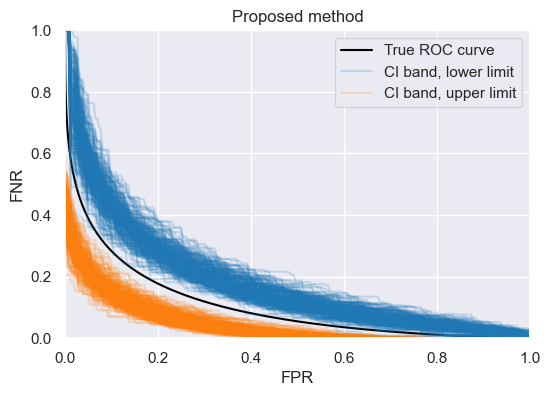

In [8]:
visualise_ci_bands(ci_method_name="Proposed method", ci_func=roc_with_ci)

  0%|          | 0/200 [00:00<?, ?it/s]

Coverage probability: 94.0%


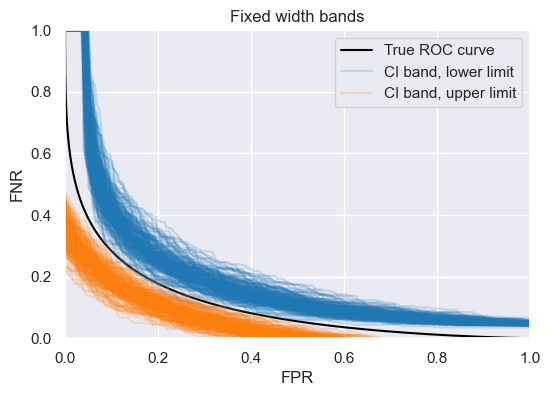

In [10]:
visualise_ci_bands(ci_method_name="Fixed width bands", ci_func=fixed_width_band_ci)

  0%|          | 0/200 [00:00<?, ?it/s]

Coverage probability: 100.0%


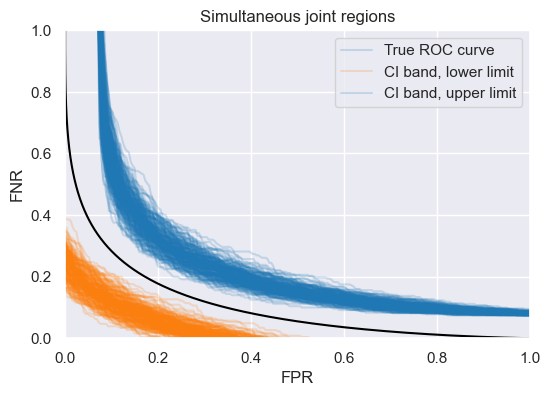

In [30]:
visualise_ci_bands(
    ci_method_name="Simultaneous joint regions", 
    ci_func=simultaneous_joint_region_ci,
)

  0%|          | 0/200 [00:00<?, ?it/s]

Coverage probability: 0.0%


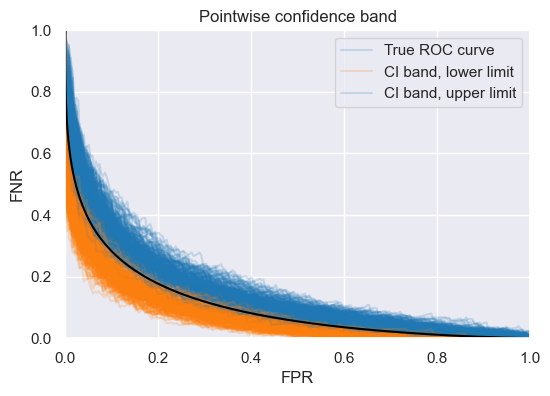

In [14]:
visualise_ci_bands(
    ci_method_name="Pointwise confidence band", 
    ci_func=pointwise_band_ci,
)

  0%|          | 0/200 [00:00<?, ?it/s]

Coverage probability: 59.0%


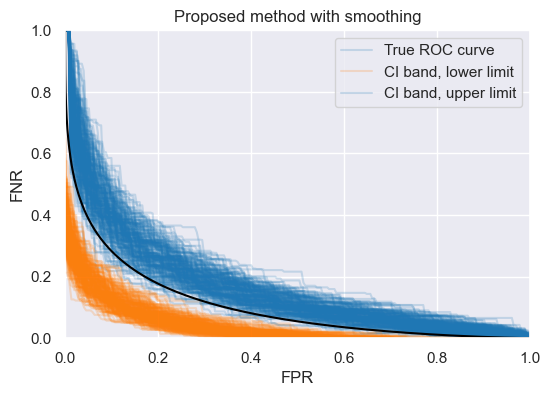

In [38]:
visualise_ci_bands(
    ci_method_name="Proposed method with smoothing", 
    ci_func=partial(
        roc_with_ci,
        config=BootstrapConfig(smoothing=True),
    ),
)

### Running bulk testing

In [31]:
def run_experiment(
    mu_pos: float, 
    n: int, 
    ci_func: Callable,
    results_file: Optional[Path] = None,
    ground_truth_source: str = "exact",
):
    # We need to reseeed the rng, because otherwise different processes will have the
    # same random numbers. This is a problem when testing variation of results, where
    # I want to run the same experiment N times.
    np.random.seed()
    
    if results_file and results_file.exists():
        return None
    
    dataset = NormalDataset(
        mu_pos=mu_pos,
        sigma_pos=3.75,
        sigma_neg=3.0,
        p_pos=0.5,
        n=n,
    )

    if ground_truth_source == "exact":
        coverage_test_func = coverage_test_exact
    elif ground_truth_source == "bootstrap_sample":
        coverage_test_func = partial(coverage_test_bootstrap, sample_source="bootstrap")
    elif ground_truth_source == "dataset_sample":
        coverage_test_func = partial(coverage_test_bootstrap, sample_source="dataset")
    else:
        raise ValueError("Unknown ground truth source.")
        
    results = coverage_test_func(
        dataset=dataset,
        ci_func=partial(
            ci_func, 
            nb_points=nb_points,
            alpha=alpha,
        ),
        nb_runs=nb_runs,
        nb_roc_points=nb_points,
        verbose=False,
    )

    if results_file:
        np.save(results_file, results)

    return results["fnr_coverage_prob"]

In [ ]:
alpha = 0.1
mu_pos_list = [5., 4., 3., 2., 1.5, 1., 0.75]
n_list = [25, 50, 100, 250, 500, 1000, 2500, 5000, 10_000, 25_000]

nb_points = 1_000
nb_runs = 1_000

ci_func = simultaneous_joint_region_ci

results_dir = Path("results/simultaneous_joint_region")
results_dir.mkdir(exist_ok=True, parents=True)

# I would like to use ProcessPoolExecutor for its nicer API, but it doesn't support
# functions defined in jupyter notebooks... Hence, the multiprocess package.
pool = multiprocess.Pool(processes=multiprocess.cpu_count() - 1)
results = dict()
for mu_pos in mu_pos_list:
    for n in n_list:
        results[(mu_pos, n)] = pool.apply_async(
            run_experiment, 
            kwds=dict(
                mu_pos=mu_pos, 
                n=n,
                ci_func=ci_func,
                results_file=results_dir / f"results_{alpha:.2f}_{mu_pos:.2f}_{n}.npy",
                ground_truth_source="exact",
            )
        )
        
for (mu_pos, n), result in results.items():
    result = result.get()
    if result is None:
        print(f"{mu_pos=} {n=}. Result exists.")
    else:
        print(f"{mu_pos=} {n=}. Coverage probability: {result:.1%}")
        
pool.terminate()
print("All done!")

## Visualisations

In [18]:
def plot_coverage_probability(method_name: str, method_dir: str):
    results_dir = Path("results") / method_dir
    mu_pos_list = [5., 4., 3., 2., 1.5, 1., 0.75]
    n_list = [25, 50, 100, 250, 500, 1000, 2500, 5000, 10_000, 25_000]
    
    fnr_coverage_prob = np.empty((len(mu_pos_list), len(n_list)))
    fpr_coverage_prob = np.empty((len(mu_pos_list), len(n_list)))
    for j, mu_pos in enumerate(mu_pos_list):
        for k, n in enumerate(n_list):
            results_file = results_dir / f"results_{alpha:.2f}_{mu_pos:.2f}_{n}.npy"
            results = np.load(results_file, allow_pickle=True).item()

            if "fnr_coverage_prob" in results:
                fnr_coverage_prob[j, k] = results["fnr_coverage_prob"]
            else:
                fnr_reduced = np.all(results["fnr_inside"], axis=-1)
                fnr_coverage_prob[j, k] = np.mean(fnr_reduced)

            if "fpr_coverage_prob" in results:
                fpr_coverage_prob[j, k] = results["fpr_coverage_prob"]
            else:
                fpr_reduced = np.all(results["fpr_inside"], axis=-1)
                fpr_coverage_prob[j, k] = np.mean(fpr_reduced)
    
    styles = itertools.cycle(
        [
            "-", "--", "-.", ":", 
            (0, (3, 5, 1, 5)),  # dashdotted
            (0, (3, 1, 1, 1)),  # densely dashdotted
            (0, (3, 5, 1, 5, 1, 5))  # dashdotdotted
        ]
    )
    plt.figure(figsize=(6, 3))
    for j, mu_pos in enumerate(mu_pos_list):
        plt.plot(
            fnr_coverage_prob[j], "k", linestyle=next(styles), label=f"mu={mu_pos}"
        )
    plt.ylim([0.50, 1.0])
    plt.xticks(range(len(n_list)), map("{:,}".format, n_list))
    plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
    plt.xlabel("Dataset size")
    plt.ylabel("Empirical coverage probability")
    plt.title(method_name)
    plt.show()

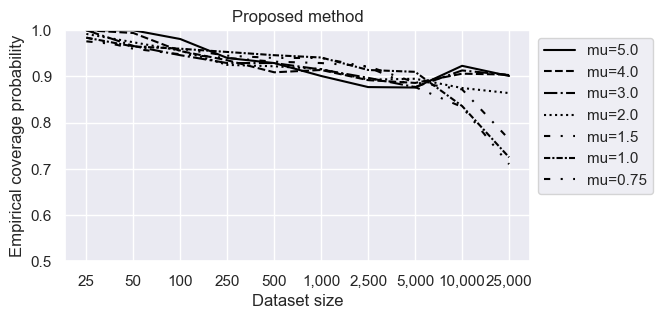

In [19]:
plot_coverage_probability("Proposed method", "roc_with_ci")

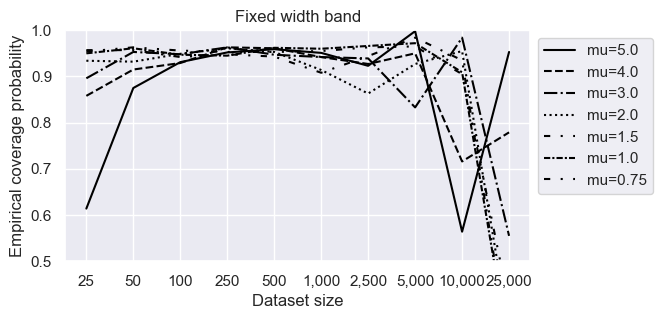

In [20]:
plot_coverage_probability("Fixed width band", "fixed_width_band")

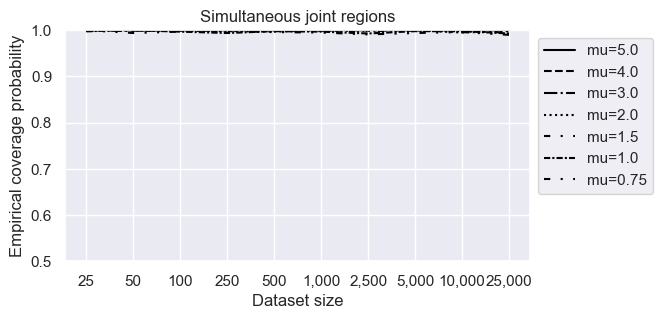

In [34]:
plot_coverage_probability("Simultaneous joint regions", "simultaneous_joint_region")

## Results variation

In [ ]:
alpha = 0.1
mu_pos = 2.0
n = 500

nb_points = 1_000
nb_runs = 1_000
nb_experiments = 18

results_dir = Path("results/variation_test")
results_dir.mkdir(exist_ok=True, parents=True)
        
pool = multiprocess.Pool(processes=multiprocess.cpu_count() - 1)
results = []
for j in range(nb_experiments):
    result = pool.apply_async(
        run_experiment, 
        kwds=dict(
            mu_pos=mu_pos, 
            n=n,
            ci_func=roc_with_ci,
            results_file=results_dir / f"experiment_{j}.npy"
        ),
    )
    results.append(result)
        
for j, result in enumerate(results):
    result = result.get()
    if result is None:
        print(f"Experiment {j}. Result exists.")
    else:
        print(f"Experiment {j}. Coverage probability: {result:.1%}")
        
pool.terminate()
print("All done!")

In [24]:
fnr_coverage_prob = np.empty(nb_experiments)
for j in range(nb_experiments):
    results_file = results_dir / f"experiment_{j}.npy"
    results = np.load(results_file, allow_pickle=True).item()
    
    fnr_reduced = np.all(results["fnr_inside"], axis=-1)
    fnr_coverage_prob[j] = np.mean(fnr_reduced)

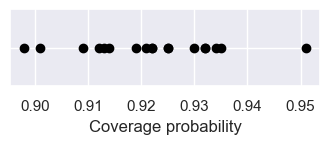

In [25]:
plt.figure(figsize=(4, 1))
plt.plot(fnr_coverage_prob, np.zeros(nb_experiments), "ko")
plt.yticks([0], [""])
plt.xlabel("Coverage probability")
plt.show()

## Test coverage with bootstrap samples

In [26]:
def coverage_test_bootstrap(
    dataset: NormalDataset,
    ci_func: Callable,
    nb_runs: int,
    nb_roc_points: int = 1_000,
    sample_source = "bootstrap",
    verbose: bool = False,
):
    x = np.linspace(0., 1., nb_roc_points, endpoint=True)
    true_fnr, true_fpr = dataset.roc(fnr=x)

    results = {
        "fnr": [], 
        "fpr": [], 
        "fnr_ci": [], 
        "fpr_ci": [], 
        "fnr_coverage_prob": [], 
        "fpr_coverage_prob": [],
    }
    
    for j in tqdm(range(nb_runs), disable=not verbose, leave=False):
        scores = dataset.sample()
        fnr, fpr, fnr_ci, fpr_ci = ci_func(scores)

        fnr_inside = []
        fpr_inside = []
        for k in range(100):
            if sample_source == "bootstrap":
                sample = scores.bootstrap_sample()
            elif sample_source == "dataset":
                sample = dataset.sample()
            else:
                raise ValueError("Unknown value for sample source.")
            sample_fnr, sample_fpr = roc(sample, fnr=x)

            # FNR is increasing and FPR is decreasing along the ROC curve, but np.interp
            # requires an increasing sequence of support points.
            lower = np.interp(sample_fpr, fpr[::-1], fnr_ci[::-1, 0])
            upper = np.interp(sample_fpr, fpr[::-1], fnr_ci[::-1, 1])
            fnr_inside.append((lower <= true_fnr) & (true_fnr <= upper))
            
            lower = np.interp(sample_fnr, fnr, fpr_ci[:, 0])
            upper = np.interp(sample_fnr, fnr, fpr_ci[:, 1])
            fpr_inside.append((lower <= true_fpr) & (true_fpr <= upper))

        fnr_inside = np.stack(fnr_inside, axis=0)
        fnr_reduced = np.all(fnr_inside, axis=-1)
        fnr_coverage_prob = np.mean(fnr_reduced)

        fpr_inside = np.stack(fpr_inside, axis=0)
        fpr_reduced = np.all(fpr_inside, axis=-1)
        fpr_coverage_prob = np.mean(fpr_reduced)
        
        results["fnr"].append(fnr)
        results["fpr"].append(fpr)
        results["fnr_ci"].append(fnr_ci)
        results["fpr_ci"].append(fpr_ci)
        results["fnr_coverage_prob"].append(fnr_coverage_prob)
        results["fpr_coverage_prob"].append(fpr_coverage_prob)

    for k, v in results.items():
        results[k] = np.stack(v, axis=0)

    results["fnr_coverage_prob"] = np.mean(results["fnr_coverage_prob"])
    results["fpr_coverage_prob"] = np.mean(results["fpr_coverage_prob"])

    return results

In [ ]:
alpha = 0.1
mu_pos_list = [5., 4., 3., 2., 1.5, 1., 0.75]
n_list = [25, 50, 100, 250, 500, 1000, 2500, 5000, 10_000, 25_000]

nb_points = 1_000
nb_runs = 100

ci_func = roc_with_ci
ground_truth_source = "dataset_sample"

results_dir = Path("results/roc_with_ci_dataset_sample_gt")
results_dir.mkdir(exist_ok=True, parents=True)

# I would like to use ProcessPoolExecutor for its nicer API, but it doesn't support
# functions defined in jupyter notebooks... Hence, the multiprocess package.
pool = multiprocess.Pool(processes=multiprocess.cpu_count() - 1)
results = dict()
for mu_pos in mu_pos_list:
    for n in n_list:
        results[(mu_pos, n)] = pool.apply_async(
            run_experiment, 
            kwds=dict(
                mu_pos=mu_pos, 
                n=n,
                ci_func=ci_func,
                results_file=results_dir / f"results_{alpha:.2f}_{mu_pos:.2f}_{n}.npy",
                ground_truth_source=ground_truth_source,
            )
        )
        
for (mu_pos, n), result in results.items():
    result = result.get()
    if result is None:
        print(f"{mu_pos=} {n=}. Result exists.")
    else:
        print(f"{mu_pos=} {n=}. Coverage probability: {result:.1%}")
        
pool.terminate()
print("All done!")

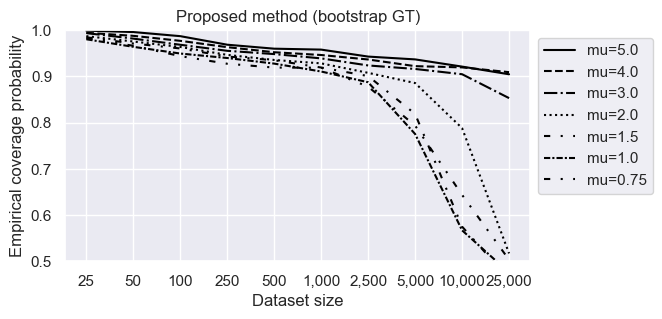

In [27]:
plot_coverage_probability("Proposed method (bootstrap GT)", "roc_with_ci_bootstrap_gt")

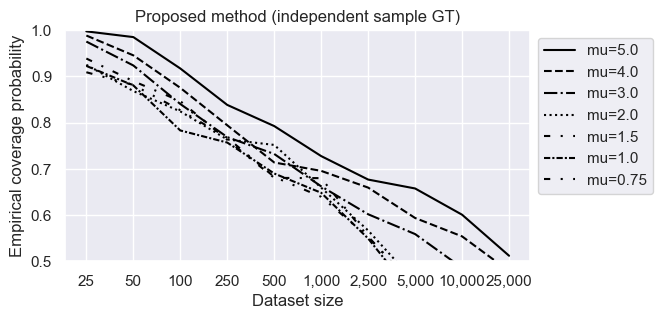

In [28]:
plot_coverage_probability("Proposed method (independent sample GT)", "roc_with_ci_dataset_sample_gt")